# Word Trends using Google NGrams

We are using wordnet to generate a word cloud around chosen words and then use google ngrams to map out the usage frequency of the concept. We are eventually interested to see if the frequency is correlated with any important historical events. 

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import nltk
from nltk.corpus import wordnet as wn
import os.path
import urllib
#%matplotlib nbagg
%matplotlib inline

see https://en.wikipedia.org/wiki/WordNet for details

In [4]:
for s in wn.synsets('war'):
    for l in s.lemmas():
        for d in l.derivationally_related_forms():
            print l, d

Lemma('war.n.01.war') Lemma('war.v.01.war')
Lemma('war.n.02.war') Lemma('war.v.01.war')
Lemma('war.v.01.war') Lemma('war.n.01.war')
Lemma('war.v.01.war') Lemma('war.n.02.war')
Lemma('war.v.01.war') Lemma('warrior.n.01.warrior')


### Generating a word cloud around the target word
from a set of synonyms chosses the ones that have similarity more than 30%

In [5]:
targetWord = 'war'
syns = wn.synsets(targetWord)
wordCloud = []
wordCloudOriginal = []
wordCloudSim = [] # similarity to the target word
for word in syns:
    for lemma in word.lemmas():
        if lemma.name() not in wordCloudOriginal:
            wordCloudOriginal.append(str(lemma.name()))
            if wn.synsets(targetWord)[0].wup_similarity(wn.synsets(lemma.name())[0]) > 0.3:
                wordCloud.append(str(lemma.name()))
                wordCloudSim.append(wn.synsets(targetWord)[0].wup_similarity(wn.synsets(lemma.name())[0]))
            
wordCloud, wordCloudOriginal, wordCloudSim

(['war', 'warfare', 'state_of_war'],
 ['war', 'warfare', 'state_of_war'],
 [1.0, 1.0, 0.3076923076923077])

the problem with this is that, this list only contains 'lemmas' and not various forms of the words (loved, lover, loving, ...)

### Creating a data frame for the word cloud
downloads the files from google ngram if they don't exist or they're broken (based on size) and then extracts the relevant frequencies

In [6]:
columns = ['ngram', 'year', 'match_count', 'volume_count']
dataf = pd.DataFrame(columns=columns)
for word in wordCloud:
    print word
    wordsp = word.split('_')
    n = len(wordsp)
    indices = word[:min(2,n)]
    filename = 'googlebooks-eng-all-{}gram-20120701-{}.gz'.format(n, indices)
    url = "http://storage.googleapis.com/books/ngrams/books/"+filename
    
    if not os.path.isfile(filename):
        urllib.urlretrieve (url, filename)
    elif int(urllib.urlopen(url).info()['Content-Length']) != os.stat(filename).st_size:
        urllib.urlretrieve (url, filename)
        
    for chunk in pd.read_table(filename, sep='\t', header=None, names=columns, chunksize=40000000):
        dataf = dataf.append(chunk[chunk.ngram == ' '.join(word.split('_'))], ignore_index=True)
        print sum(chunk.ngram == ' '.join(word.split('_')))
        
dataf.tail()

war
403
warfare
354
state_of_war
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


,ngram,year,match_count,volume_count
752,warfare,2004,179680,34146
753,warfare,2005,166935,32690
754,warfare,2006,185914,35475
755,warfare,2007,206729,39417
756,warfare,2008,240597,56461


### saving the dataframe

In [7]:
dataf.to_csv('dataset_for_'+targetWord+'_wordCloud.csv.gz', sep=',', compression='gzip')

### plotting each word vs years

(0, 50)

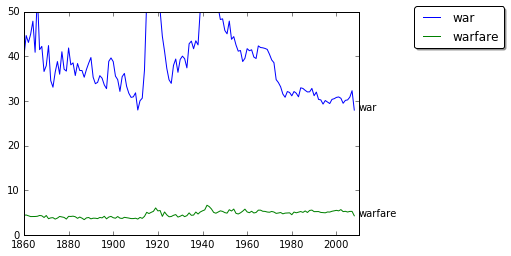

In [8]:
for key, grp in dataf.groupby(by='ngram'):
    plt.plot(grp.year, grp.match_count/grp.volume_count, label=key)
    plt.annotate(key, xy=(2010, grp.match_count[grp.year==2008]/grp.volume_count[grp.year==2008]))
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1.05), ncol=1, fancybox=True, shadow=True)
plt.xlim(1860,2010)
plt.ylim(0,50)

In [9]:
#data_check = pd.read_table('googlebooks-eng-all-1gram-20120701-d.gz', sep='\t', header=None, names=columns)

In [10]:
#plt.plot(data_check[data_check.ngram=='dog'].year, \
#         data_check[data_check.ngram=='dog'].match_count/data_check[data_check.ngram=='dog'].volume_count)
#plt.xlim(1850,2016)
#plt.ylim(5,12)

### plotting the concept (all words) vs years
using a gaussian filter for smoothing

In [11]:
dataf_groups = dataf.groupby(by='year', as_index=True).sum()

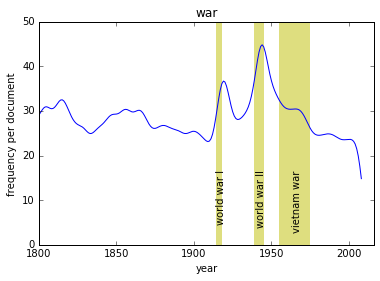

In [37]:
gausFilter = signal.gaussian(50,3)/signal.gaussian(50,3).sum()
trend = np.convolve(dataf_groups.match_count/dataf_groups.volume_count, gausFilter, mode='same')

plt.plot(dataf_groups.index.values, trend)
# plt.plot(dataf[dataf.ngram=='love'].year, dataf[dataf.ngram=='love'].match_count/dataf[dataf.ngram=='love'].volume_count)
# plt.plot(dataf_groups.index.values, dataf_groups.match_count)
plt.axvspan(1914, 1918, color='y', alpha=0.5, lw=0)
plt.annotate('world war I', xy=(1914,15), rotation=np.degrees(3.14/2))
plt.axvspan(1939, 1945, color='y', alpha=0.5, lw=0)
plt.annotate('world war II', xy=(1940,15), rotation=np.degrees(3.14/2))
plt.axvspan(1955, 1975, color='y', alpha=0.5, lw=0)
plt.annotate('vietnam war', xy=(1963,15), rotation=np.degrees(3.14/2))
#plt.axvspan(1960, 2008, color='y', alpha=0.5, lw=0)
#plt.annotate('women liberation', xy=(1968,8), rotation=np.degrees(3.14/2))
plt.xlim(1800,2016)
plt.ylim(0,50)
plt.title(targetWord)
plt.xlabel('year')
plt.ylabel('frequency per document')
plt.savefig('dataset_for_'+targetWord+'_wordCloud.png')

In [23]:
trend.shape

(404L,)